# Ensemble Resilience Comparison

Compare stochastic playback statistics across synthetic small, medium, and large scenarios.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'pyproject.toml').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'pyproject.toml').exists():
    raise RuntimeError('Notebook must be executed within a FHOPS checkout (pyproject.toml not found).')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from docs.examples.analytics import utils

import pandas as pd
from IPython.display import display
from fhops.scenario.synthetic import SyntheticDatasetConfig, sampling_config_for

SCENARIOS = [
    ('small', PROJECT_ROOT / 'examples/synthetic/small/scenario.yaml', PROJECT_ROOT / 'docs/examples/analytics/data/synthetic_small_sa_assignments.csv'),
    ('medium', PROJECT_ROOT / 'examples/synthetic/medium/scenario.yaml', PROJECT_ROOT / 'docs/examples/analytics/data/synthetic_medium_sa_assignments.csv'),
    ('large', PROJECT_ROOT / 'examples/synthetic/large/scenario.yaml', PROJECT_ROOT / 'docs/examples/analytics/data/synthetic_large_sa_assignments.csv'),
]

summary_rows = []
ensemble_tables = {}
for tier, scenario_path, assign_path in SCENARIOS:
    config = SyntheticDatasetConfig(name=f'synthetic-{tier}', tier=tier, num_blocks=8, num_days=12, num_machines=4)
    tables, sampling = utils.run_stochastic_summary(scenario_path, assign_path, tier=tier)
    ensemble_tables[tier] = tables
    production = tables.shift.groupby('sample_id')['production_units'].sum()
    downtime = tables.shift.groupby('sample_id')['downtime_hours'].sum()
    summary_rows.append({
        'tier': tier,
        'mean_production': production.mean(),
        'std_production': production.std(),
        'mean_downtime_hours': downtime.mean(),
        'samples': tables.shift['sample_id'].nunique(),
    })
summary_df = pd.DataFrame(summary_rows)
summary_df

,tier,mean_production,std_production,mean_downtime_hours,samples
0,small,31.492000,0.000000,0.0,6
1,medium,21.201420,4.298647,0.0,12
2,large,18.251055,4.878283,0.0,18


## Production Distributions

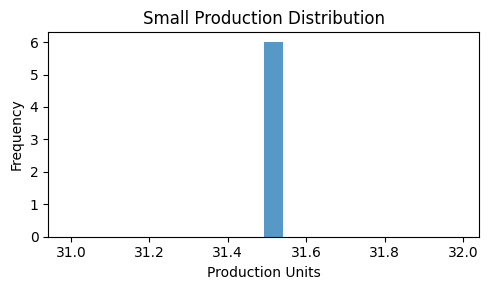

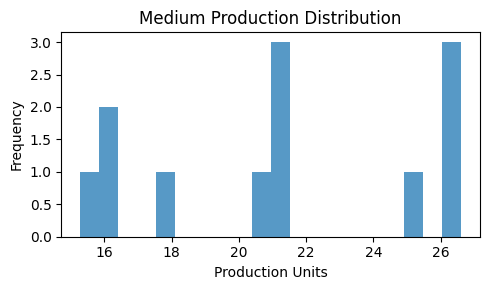

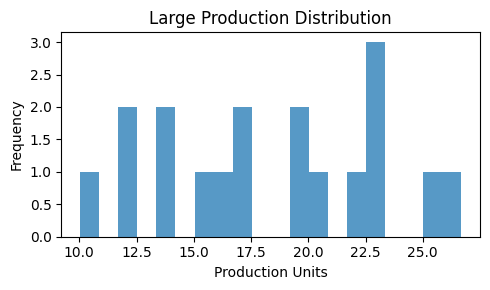

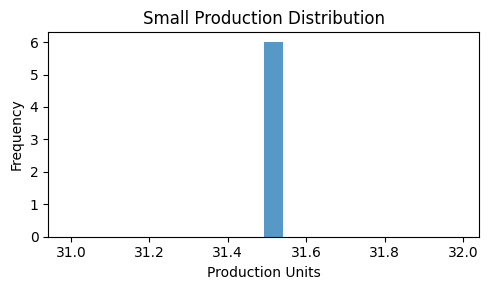

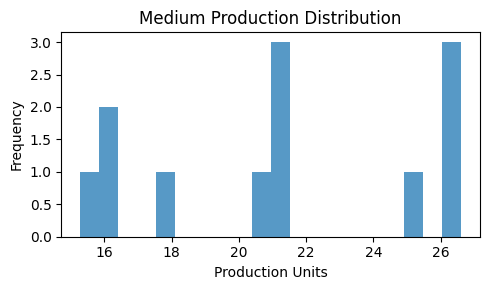

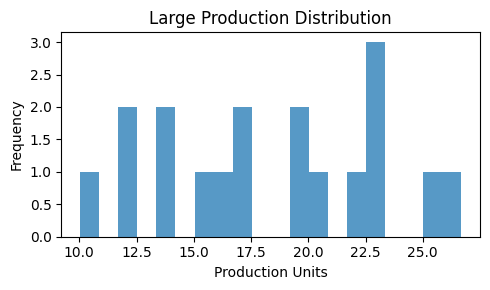

In [2]:
for tier, tables in ensemble_tables.items():
    prod = tables.shift.groupby('sample_id')['production_units'].sum()
    display(utils.plot_distribution(prod, title=f'{tier.title()} Production Distribution', xlabel='Production Units'))

## Downtime Summary

In [3]:
downtime_summary = pd.DataFrame({
    tier: tables.shift.groupby('sample_id')['downtime_hours'].sum()
    for tier, tables in ensemble_tables.items()
})
downtime_summary.describe()

,small,medium,large
count,6.0,12.0,18.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0
